In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import autograd.numpy as np
from autograd import grad 

# element-wise gradient is a standard-alone function in v1.2
from autograd import elementwise_grad as egrad

import autograd.numpy.random as npr
from autograd.misc.flatten import flatten_func, flatten

from scipy.integrate import solve_ivp # for comparision
from scipy.optimize import minimize

In [2]:
# It is easier to write NN with separate functions

def f1(t, y):
    return 998*y[0] + 1998*y[1]

def f2(t, y):
    return -999*y[0] - 1999*y[1]
    
f_list = [f1, f2]
    
def f(t, y):
    '''
        dy/dt = f(t, y)
        This is f() function on the right
    '''    
    
    return [f(t, y) for f in f_list]

# Reference solution

In [3]:
t0, tmax = [0, 2]

#y0_list = [1, 0] # rapid increase and then decay. Can't solve by NN!
y0_list = [2, -1] # simply decay. Can be solved by NN easily

# Radau is an implicit solver. Explicit solver like RK45 needs far more time steps.
sol = solve_ivp(f, [t0, tmax], y0_list, method='Radau', rtol=1e-5)

In [4]:
sol.y.shape

(2, 13)

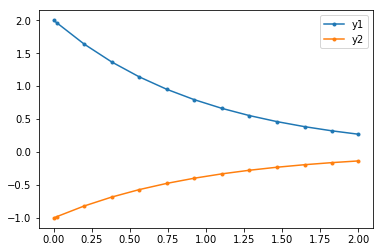

In [5]:
plt.plot(sol.t, sol.y[0], marker='.', label='y1')
plt.plot(sol.t, sol.y[1], marker='.', label='y2')
plt.legend()

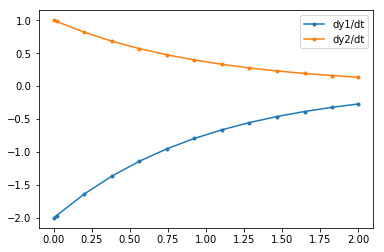

In [6]:
plt.plot(sol.t, f1(sol.t, sol.y), marker='.', label='dy1/dt')
plt.plot(sol.t, f2(sol.t, sol.y), marker='.', label='dy2/dt')
plt.legend()

# Build NN

In [7]:
t = np.linspace(0, 2.0, 11).reshape(-1,1) # training points

In [8]:
def init_weights(n_in=1, n_hidden=10, n_out=1):
    W1 = npr.randn(n_in, n_hidden)
    b1 = np.zeros(n_hidden)
    W2 = npr.randn(n_hidden, n_out)
    b2 = np.zeros(n_out)
    params = [W1, b1, W2, b2]
    return params

params1 = init_weights()
params2 = init_weights()
params_list = [params1, params2]
print([ p.shape for p in params1 ])

[(1, 10), (10,), (10, 1), (1,)]


In [9]:
def predict(params, t, y0, act=np.tanh):
    W1, b1, W2, b2 = params
    
    a = act(np.dot(t, W1) + b1)
    y = np.dot(a, W2) + b2
    
    phi = y0 + t*y
    
    return phi

In [10]:
predict(params1, t, y0_list[1]).shape # vectorized over t

(11, 1)

In [11]:
predict_dt = egrad(predict, argnum=1) # element-wise grad w.r.t t, 

In [12]:
predict_dt(params1, t, y0_list[1]).shape

(11, 1)

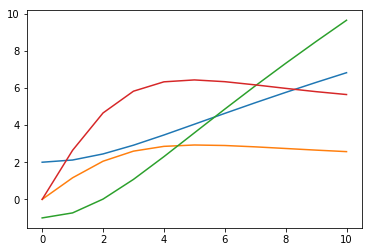

In [13]:
plt.plot(predict(params1, t, y0_list[0]))
plt.plot(predict_dt(params1, t, y0_list[0]))
plt.plot(predict(params2, t, y0_list[1]))
plt.plot(predict_dt(params2, t, y0_list[1]))

In [14]:
def loss_func(params_list, t, y0_list):
    
    
    y_pred_list = []
    dydt_pred_list = []
    for params, y0 in zip(params_list, y0_list):
        y_pred =  predict(params, t, y0)
        dydt_pred = predict_dt(params, t, y0)
        
        y_pred_list.append(y_pred.squeeze())
        dydt_pred_list.append(dydt_pred.squeeze())
        
    f_pred_list = f(t, y_pred_list)
    
    loss_total = 0.0
    for f_pred, dydt_pred in zip(f_pred_list, dydt_pred_list):
        loss = np.sum( (dydt_pred-f_pred)**2 )
        loss_total += loss
    
    return loss_total 

In [15]:
loss_func(params_list, t, y0_list)

4741082637.9130135

In [16]:
flattened_params, unflat_func = flatten(params_list)

In [17]:
def loss_part(flattened_params):
    '''make partial function. 
    Use this simple method because
    autograd or scipy does not like functool.partial'''
    
    params_list = unflat_func(flattened_params) # recover
    
    # warning: global t and y0 are used
    return loss_func(params_list, t, y0_list)

In [18]:
loss_part(flattened_params)

4741082637.9130135

In [19]:
loss_part_grad = grad(loss_part)

In [20]:
loss_part_grad(flattened_params).shape

(62,)

In [21]:
%%time
count = 0
def print_loss(x):
    global count
    if count %200 == 0:  
        print("iteration:", count, "loss: ", loss_part(x))
    count += 1
        
o = minimize(loss_part, x0=flattened_params, jac=loss_part_grad, 
             method="BFGS", callback=print_loss, 
             options = {'disp': True, 'maxiter': 1000})

iteration: 0 loss:  976187110.43
iteration: 200 loss:  0.0212938064272
iteration: 400 loss:  0.000761527506199
iteration: 600 loss:  0.000106923722919
iteration: 800 loss:  5.48614459116e-05
         Current function value: 0.000046
         Iterations: 1000
         Function evaluations: 1187
         Gradient evaluations: 1187
CPU times: user 6.93 s, sys: 48 ms, total: 6.98 s
Wall time: 7.04 s


In [22]:
loss_part(o.x)

4.6302701535579497e-05

In [23]:
print(o.fun, o.njev, o.nfev, '\n', o.message)

4.63027015355795e-05 1187 1187 
 Maximum number of iterations has been exceeded.


In [24]:
params1_opt, params2_opt = unflat_func(o.x)

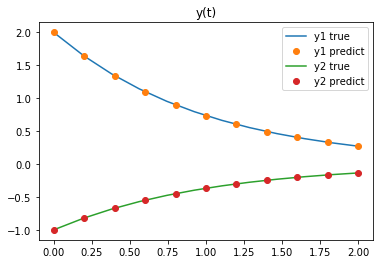

In [25]:
plt.plot(sol.t, sol.y[0], label='y1 true')
plt.plot(t, predict(params1_opt, t, y0_list[0]), 'o', label='y1 predict')

plt.plot(sol.t, sol.y[1], label='y2 true')
plt.plot(t, predict(params2_opt, t, y0_list[1]), 'o', label='y2 predict')

plt.legend()
plt.title('y(t)')

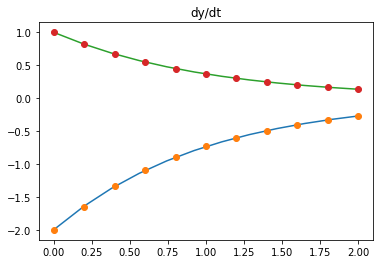

In [26]:
plt.plot(sol.t, f1(sol.t, sol.y))
plt.plot(t, predict_dt(params1_opt, t, y0_list[0]), 'o')

plt.plot(sol.t, f2(sol.t, sol.y))
plt.plot(t, predict_dt(params2_opt, t, y0_list[1]), 'o')

plt.title('dy/dt')